In [90]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from tbcontrol.symbolic import routh

In [91]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [92]:
s = ctl.TransferFunction.s
G = 0.0218891424389763*s/(1.0*s - 3.592525994444)

G_bkp = G
G

TransferFunction(array([0.02188914, 0.        ]), array([ 1.        , -3.59252599]))

polos:  (3.593+0j)
zeros:  0j


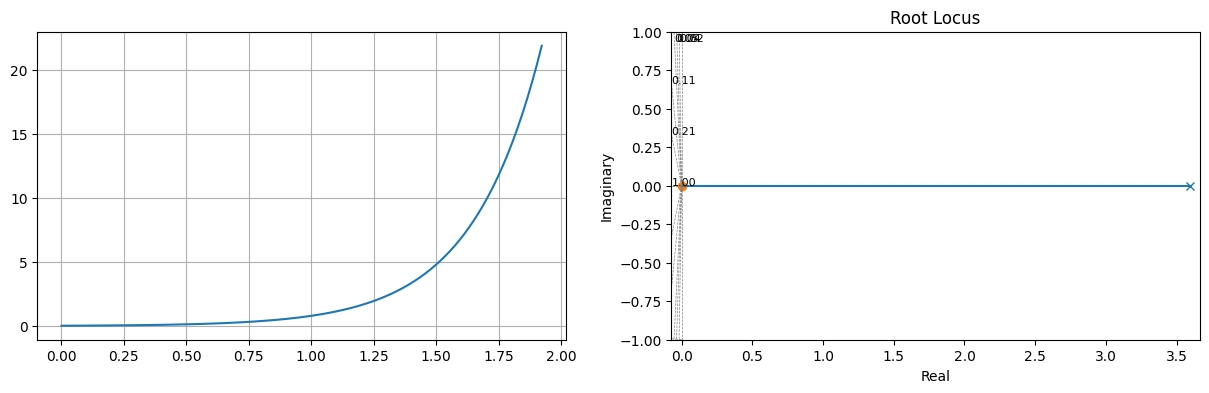

In [93]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# INFORMAÇÕES DA RESPOSTA

In [94]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 21.88914243897647,
 'peakTime': 1.922812886995191,
 'settlingTime': None,
 'finalValue': 21.88914243897647,
 'error': 20.88914243897647}

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K_p \, \big(1 + \frac{1}{T_is}\big)\big(\frac{T_ds + 1}{0.1T_ds + 1}\big)$

In [95]:
s = ctl.TransferFunction.s

In [96]:
def getControllerResponse(Kp, Ti, Td):
    C     = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
    G_ma = G*C

    error = 1/(1 + G_ma(0.00001))

    if error > 0.1:
        return None

    time, response = ctl.step_response(ctl.feedback(G_ma, 1), T=np.linspace(0, 20, 100))
    data = getAllInfo(time, response, show=False)

    if data.get('settlingTime') is None:
        return None
    
    data['Kp'] = Kp
    data['Ti'] = Ti
    data['Td'] = Td
    return data

getControllerResponse(1, 1, 1)

In [97]:
Kp_data = np.linspace(0.01, 100, 10)
Ti_data = np.linspace(0.01, 5, 10)
Td_data = np.linspace(0.01, 5, 10)

In [98]:
data = []

for Kp in Kp_data:
    for Ti in Ti_data:
        for Td in Td_data:
            response = getControllerResponse(Kp, Ti, Td)

            if response is None:
                continue
            
            data.append(response)

### ANÁLISE DOS DADOS

In [99]:
df = pd.DataFrame(data)

In [100]:
df = df.loc[(df.settlingTime > 5) & (df.settlingTime < 20)]
df.head()

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
4,0.0,1.173063,20.0,5.252525,1.173063,0.173063,11.12,0.01,2.227778
5,0.0,1.172774,20.0,6.262626,1.172774,0.172774,11.12,0.01,2.782222
6,0.0,1.172136,20.0,7.070707,1.172136,0.172136,11.12,0.01,3.336667
7,0.0,1.171084,20.0,7.878788,1.171084,0.171084,11.12,0.01,3.891111
8,0.0,1.169618,20.0,8.282828,1.169618,0.169618,11.12,0.01,4.445556


In [101]:
df = df.loc[(df.overshoot >= 0.00) & (df.overshoot < 0.5)]
df.head()

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
4,0.0,1.173063,20.0,5.252525,1.173063,0.173063,11.12,0.01,2.227778
5,0.0,1.172774,20.0,6.262626,1.172774,0.172774,11.12,0.01,2.782222
6,0.0,1.172136,20.0,7.070707,1.172136,0.172136,11.12,0.01,3.336667
7,0.0,1.171084,20.0,7.878788,1.171084,0.171084,11.12,0.01,3.891111
8,0.0,1.169618,20.0,8.282828,1.169618,0.169618,11.12,0.01,4.445556


In [102]:
df = df.loc[(df.error > 0.01) & (df.error < 0.5)]
df.head()

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
4,0.0,1.173063,20.0,5.252525,1.173063,0.173063,11.12,0.01,2.227778
5,0.0,1.172774,20.0,6.262626,1.172774,0.172774,11.12,0.01,2.782222
6,0.0,1.172136,20.0,7.070707,1.172136,0.172136,11.12,0.01,3.336667
7,0.0,1.171084,20.0,7.878788,1.171084,0.171084,11.12,0.01,3.891111
8,0.0,1.169618,20.0,8.282828,1.169618,0.169618,11.12,0.01,4.445556


In [103]:
row = df.iloc[0].to_dict()
Kp, Ti, Td = row['Kp'], row['Ti'], row['Td']
Kp, Ti, Td

(11.12, 0.01, 2.227777777777778)

# RESPOSTA CONTROLADA

In [104]:
s  = ctl.TransferFunction.s

C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
C

TransferFunction(array([ 0.24772889, 24.88408889, 11.12      ]), array([0.00222778, 0.01      , 0.        ]))

In [105]:
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([0.00542257, 0.54469137, 0.24340726, 0.        ]), array([ 0.00222778,  0.00199665, -0.03592526,  0.        ]))

In [106]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([0.00542257, 0.54469137, 0.24340726, 0.        ]), array([0.00765035, 0.54668802, 0.207482  , 0.        ]))

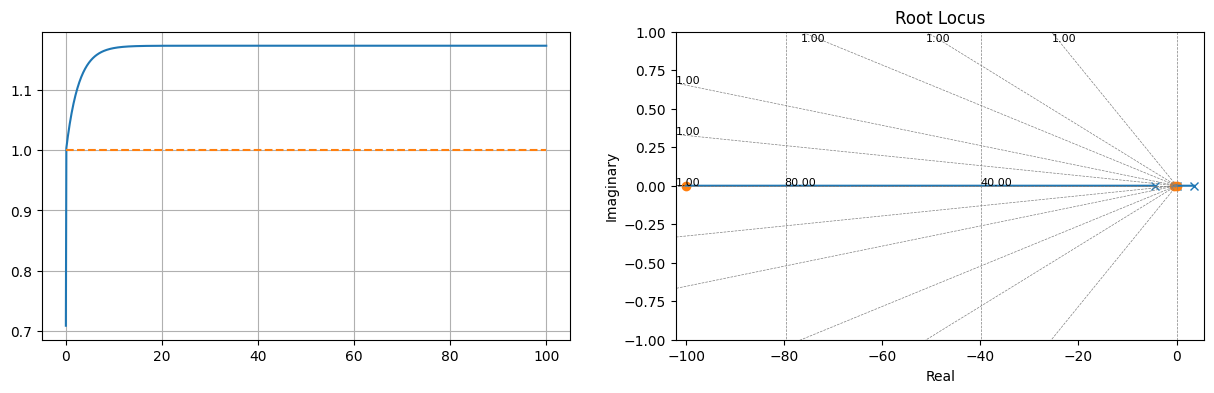

In [107]:
time, response = ctl.step_response(G_feedback, T=np.linspace(0, 100, 1000))
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [108]:
getAllInfo(time, response, setpoint=1)

overshoot:  0.0
valor de pico:  1.173148799683013
tempo de pico:  86.78678678678679
tempo de assentamento:  5.305305305305305
valor final:  1.173148799683013
erro:  0.173148799683013


# APLICANDO VÁRIOS STEPS

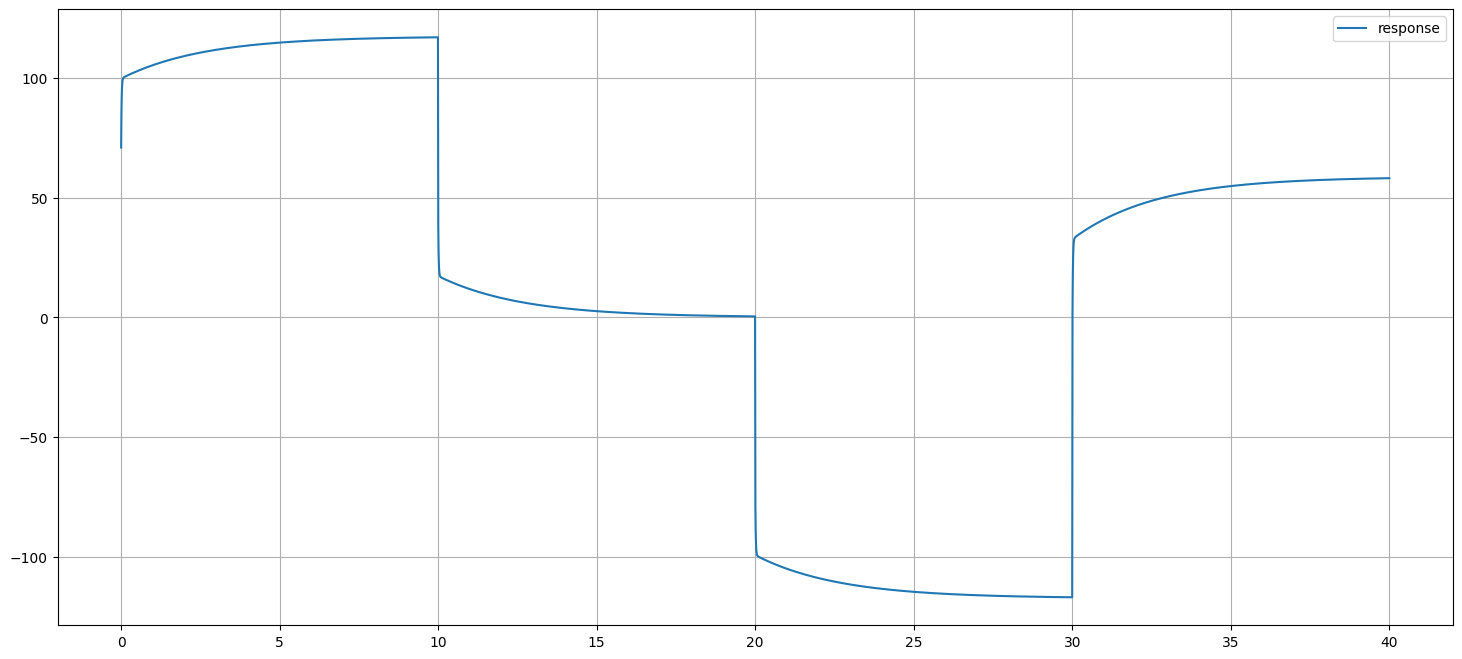

In [109]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()

In [110]:
print(sympyFunction(C))

(0.247728888888889*s**2 + 24.8840888888889*s + 11.12)/(0.00222777777777778*s**2 + 0.01*s)


In [111]:
print(ctl.poles(C))
print(ctl.zeros(C))

[-4.48877805+0.j  0.        +0.j]
[-100.        +0.j   -0.44887781+0.j]
